In [1]:
from typing import Dict, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
import pyesg

from scipy.stats import norm, multivariate_normal
from scipy.optimize import least_squares, minimize

C:\ProgramData\Anaconda3\lib\site-packages\dask\config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\ProgramData\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [21]:
from pyesg.datasets import load_ust_historical

data = load_ust_historical()
X = np.array([0.25, 0.5, 1, 2, 3, 5, 7, 10, 20, 30])
y = data.iloc[-10].values

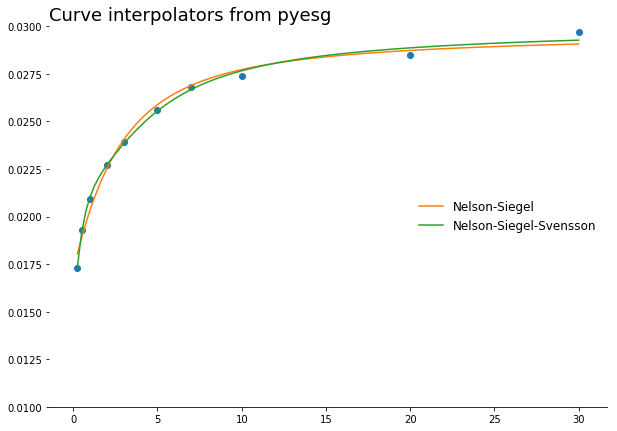

In [27]:
fig, ax = plt.subplots(figsize=(10,7))
ax.set_title('Curve interpolators from pyesg', loc='left', fontsize=18)

ns = pyesg.NelsonSiegel().fit(X, y)
nss = pyesg.NelsonSiegelSvensson().fit(X, y)

x = np.arange(1, 121) / 4
ax.plot(x, ns.predict(x), color='C1', label='Nelson-Siegel')
ax.plot(x, nss.predict(x), color='C2', label='Nelson-Siegel-Svensson')
ax.scatter(X, y)

ax.set_ylim(0.01, 0.03)
ax.legend(frameon=False, fontsize=12, loc='center right')
for s in ['top', 'right', 'left']:
    ax.spines[s].set_visible(False)

plt.savefig('20191031-pyesg.png', bbox_inches='tight', dpi=300)
plt.show()

In [19]:
# Vasicek Model
data = pyesg.datasets.load_ust_historical()
X = pd.to_datetime(
    data.index.get_level_values('year').astype(str)
    + "-" + data.index.get_level_values('month').astype(str)
)
X = ((X - X[0]) / np.timedelta64(365, 'D')).values
y = data.iloc[:, 0].values

model = pyesg.Vasicek()
model.fit(X, y)
model._fitted_params

{'k': 0.12246729732457176,
 'theta': 0.04439939525048735,
 'sigma': 0.015511293531658898}

In [16]:
X = pd.to_datetime(
    data.index.get_level_values('year').astype(str)
    + "-" + data.index.get_level_values('month').astype(str)
)
X = (X - X[0]) / np.timedelta64(365, 'D')

Float64Index([                0.0,  0.0821917808219178, 0.16712328767123288,
               0.2493150684931507, 0.33424657534246577,  0.4191780821917808,
               0.5013698630136987,  0.5863013698630137,  0.6684931506849315,
               0.7534246575342466,
              ...
                64.95890410958904,   65.04383561643836,   65.12602739726027,
                65.21095890410959,    65.2931506849315,   65.37808219178082,
                65.46301369863014,   65.54520547945205,   65.63013698630137,
                65.71232876712328],
             dtype='float64', length=789)

In [4]:
# Vasicek Model
X = pd.to_datetime(
    data.index.get_level_values('year').astype(str)
    + "-" + data.index.get_level_values('month').astype(str)
)
X = np.diff(X).astype('timedelta64[D]').astype(np.float) / 365
X = np.append([0], X)
X = np.full()


vasicek = pyesg.Vasicek()
vasicek.fit(X, y)

RuntimeError: Model failed to converge

In [5]:
v = pyesg.Vasicek

In [9]:
from io import StringIO
data = """0, 3
    0.25, 1.76
    0.5, 1.2693
    0.75, 1.196
    1, 0.9468
    1.25, 0.9532
    1.5, 0.6252
    1.75, 0.8604
    2, 1.0984
    2.25, 1.431
    2.5, 1.3019
    2.75, 1.4005
    3, 1.2686
    3.25, 0.7147
    3.5, 0.9237
    3.75, 0.7297
    4, 0.7105
    4.25, 0.8683
    4.5, 0.7406
    4.75, 0.7314
    5, 0.6232"""
data = pd.read_csv(StringIO(data), header=None, index_col=[0])
X = data.index.values
y = data.values

In [12]:
v = pyesg.Vasicek()
v.fit(X, y)
v._fitted_params

{'k': 3.1286885821300157,
 'theta': 0.9074884514128012,
 'sigma': 0.553151436210664}

In [14]:
v._log_likelihood(**v._fitted_params, X=X, y=y)

82.9739917411932

In [15]:
y = data.iloc[:, 0].values
X = np.full(len(y), 1/12).cumsum()
k, theta, sigma = 0.12, 0.045, 0.00025

B = (1 - np.exp(-k*(X[1:] - X[:-1]))) / k
m = theta*k*B + y[:-1]*(1 - k*B)
v = sigma**2*(B - k/2*B**2)
ll = (np.log(2*np.pi*v) + (y[1:] - m)**2 / v).sum() / -2
ll.sum()

-247659795.39951685

In [19]:
def _log_likelihood(k, theta, sigma, X, y):
    """Vasicek log-likelihood"""
    B = (1 - np.exp(-k * (X[1:] - X[:-1]))) / k
    m = theta * k * B + y[:-1] * (1 - k * B)
    v = sigma ** 2 * (B - k / 2 * B ** 2)
    return (np.log(2 * np.pi * v) + (y[1:] - m) ** 2 / v).sum() / -2

y = pyesg.datasets.load_ust_historical().iloc[:, 0].values
X = np.full(len(y), 1/12).cumsum()
k, theta, sigma = 0.12, .0444, .0155
_log_likelihood(k, theta, sigma, X, y)

3147.8885135309156

In [22]:
y = pyesg.datasets.load_ust_historical().iloc[:, 0].values
X = np.full(len(y), 1/12).cumsum()
k, theta, sigma = 0.12, .0444, .0155
pyesg.Vasicek._log_likelihood(k, theta, sigma, X, y)

3147.8885135309156

In [24]:
minimize(
    fun=lambda params, X, y: -pyesg.Vasicek._log_likelihood(*params, X=X, y=y),
    x0=[0.1, 0.1, 0.1],
    args=(X, y),
    method='Nelder-Mead'
)

 final_simplex: (array([[0.12248459, 0.04439871, 0.01551149],
       [0.12250002, 0.0444075 , 0.01551162],
       [0.12239876, 0.04441123, 0.01551098],
       [0.12249818, 0.04439322, 0.01551132]]), array([-3147.88962067, -3147.88962035, -3147.88962029, -3147.88962015]))
           fun: -3147.8896206679187
       message: 'Optimization terminated successfully.'
          nfev: 195
           nit: 109
        status: 0
       success: True
             x: array([0.12248459, 0.04439871, 0.01551149])

In [31]:
vasicek = pyesg.Vasicek()
vasicek.fit(X, y)
print(f"k: {vasicek.k}")
print(f"theta: {vasicek.theta}")
print(f"sigma: {vasicek.sigma}")

k: 0.12239234654043035
theta: 0.04439385050340855
sigma: 0.015511420167043384


In [30]:
vasicek.k

0.12239234654043035

In [176]:
minimize(
    lambda params, X, y: -1*_log_likelihood(*params, X, y),
    x0=[0.12, 0.045, 0.0001],
    args=(X, y),
)

      fun: -3147.8896211956644
 hess_inv: array([[ 6.27761352e-05,  2.80723907e-04, -3.02657702e-05],
       [ 2.80723907e-04,  1.26390318e-03, -1.40609627e-04],
       [-3.02657702e-05, -1.40609627e-04,  1.94933442e-05]])
      jac: array([-0.00012207,  0.        ,  0.00704956])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 451
      nit: 53
     njev: 90
   status: 2
  success: False
        x: array([0.1224242 , 0.04440336, 0.01551145])

In [ ]:
np.timedelta64()

In [155]:
def _log_likelihood(k, theta, sigma, X, y):
    """Vasicek log-likelihood"""
    B = lambda k, s, t: (1 - np.exp(-k*(t - s))) / k
    m = lambda k, theta, r, s, t: theta*k*B(k, s, t) + r*(1 - k*B(k, s, t))
    v = lambda k, sigma, s, t: sigma**2*(B(k, s, t) - k/2*B(k, s, t)**2)
    
    log_likelihood = (
        np.log(2*np.pi*v(k, sigma, X[:-1], X[1:]))
        + (y[1:] - m(k, theta, y[1:], X[:-1], X[1:]))**2 / (v(k, sigma, X[:-1], X[1:]))
    )
    
    return -log_likelihood.sum() / 2
    
y = data.iloc[:, 0].values
X = np.full(len(y), 1/12).cumsum()
k, theta, sigma = 0.12, 0.045, 0.00025
_log_likelihood(k, theta, sigma, X, y)

-696.0067329894378

In [143]:
minimize(
    lambda params, X, y: -1*_log_likelihood(*params, X, y),
    x0=[0.1, 0.05, 0.001],
    args=(X, y),
)

      fun: -11168.107779570386
 hess_inv: array([[8.45898733e-12, 1.92142184e-10, 7.95551282e-14],
       [1.92142184e-10, 4.20229947e-07, 3.65480216e-13],
       [7.95551282e-14, 3.65480216e-13, 1.29143010e-15]])
      jac: array([ 8.20640031e+06, -2.99929077e+03,  4.23128890e+08])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 409
      nit: 8
     njev: 80
   status: 2
  success: False
        x: array([6.05150993e-05, 3.78721469e-02, 7.05556267e-07])

In [139]:
vasicek = Vasicek().fit(X, y)

In [142]:
print(f"k: {vasicek.k}")
print(f"theta: {vasicek.theta}")
print(f"sigma: {vasicek.sigma}")

k: 0.12211654370699075
theta: 0.04434790347627699
sigma: 0.00026370371323960497


In [48]:
y

array([2.190e-02, 2.160e-02, 2.110e-02, 2.040e-02, 2.040e-02, 1.790e-02,
       1.380e-02, 1.440e-02, 1.600e-02, 1.180e-02, 9.700e-03, 1.030e-02,
       9.700e-03, 7.600e-03, 6.400e-03, 7.200e-03, 9.200e-03, 1.010e-02,
       9.800e-03, 9.300e-03, 1.150e-02, 1.220e-02, 1.170e-02, 1.280e-02,
       1.590e-02, 1.450e-02, 1.410e-02, 1.600e-02, 1.900e-02, 2.070e-02,
       2.230e-02, 2.240e-02, 2.540e-02, 2.410e-02, 2.320e-02, 2.250e-02,
       2.600e-02, 2.610e-02, 2.490e-02, 2.310e-02, 2.600e-02, 2.840e-02,
       2.900e-02, 2.990e-02, 3.210e-02, 3.110e-02, 3.100e-02, 3.080e-02,
       3.070e-02, 3.060e-02, 3.290e-02, 3.160e-02, 3.370e-02, 3.530e-02,
       3.580e-02, 3.310e-02, 3.040e-02, 2.440e-02, 1.530e-02, 1.300e-02,
       1.130e-02, 9.100e-03, 8.300e-03, 9.100e-03, 1.690e-02, 2.440e-02,
       2.630e-02, 2.670e-02, 2.770e-02, 2.820e-02, 2.700e-02, 2.800e-02,
       2.950e-02, 2.840e-02, 3.210e-02, 3.200e-02, 3.380e-02, 4.040e-02,
       4.050e-02, 4.150e-02, 4.490e-02, 4.350e-02, 

In [51]:
class Vasicek:
    """
    Vasicek stochastic short-rate model

    r(t) = r(t) + k*(theta - r(t))*dt + sigma*dt**0.5*norm(0,1)

    Parameters
    ----------
    k : float, the rate of mean reversion - fit by MLE
    theta : float, the long-term interest rate level - fit by MLE
    sigma : float, the volatility of rates - fit by MLE
    """

    def __init__(self) -> None:
        self.k: Optional[float] = None  # fit parameter
        self.theta: Optional[float] = None  # fit parameter
        self.sigma: Optional[float] = None  # fit parameter

    def __repr__(self) -> str:
        return "Vasicek Model"

    @classmethod
    def _log_likelihood(
        cls, k: float, theta: float, sigma: float, X: np.ndarray, y: np.ndarray
    ) -> float:
        """
        Log likelihood function, given model parameters and observed data

        Reference
        ---------
        https://pdfs.semanticscholar.org/dc0c/75b5d0002607046277a6768b9b54f34877c3.pdf
        """
        B = (1 - np.exp(-k * (X[1:] - X[:-1]))) / k
        m = theta * k * B + y[:-1] * (1 - k * B)
        v = sigma ** 2 * (B - k / 2 * B ** 2)
        return (np.log(2 * np.pi * v) + (y[1:] - m) ** 2 / v).sum() / -2

    @property
    def _fitted_params(self) -> Dict:
        """
        Returns a dictionary of fitted model parameters.
        Parameters default to None if they haven't been fitted yet.
        """
        return dict(k=self.k, theta=self.theta, sigma=self.sigma)

    @property
    def _check_fitted(self) -> bool:
        """Returns a boolean indicating whether or not the model has been fitted"""
        return all(x is not None for x in self._fitted_params.values())

    def fit(self, X: np.ndarray, y: np.ndarray) -> "Vasicek":
        """
        Fits the parameters of the Vasicek model using maximum likelihood.

        Parameters
        ----------
        X : np.array of timesteps in years,
            e.g. array([ 0.08333333,  0.16666667,  0.25]
        y : np.array of short-rates at each timestep
            e.g. array([2.190e-02, 2.160e-02, 2.110e-02]
        """
        # minimize the negative log-likelihood
        f = lambda params, X, y: -1 * self._log_likelihood(*params, X=X, y=y)
        mle = minimize(f, x0=[0.5, 0.1, 0.1], args=(X, y), method="Nelder-Mead")
        if mle.success:
            self.k, self.theta, self.sigma = mle.x
            return self
        else:
            raise RuntimeError("Model failed to converge")


In [62]:
from io import StringIO

data = """0, 3
0.25, 1.76
0.5, 1.2693
0.75, 1.196
1, 0.9468
1.25, 0.9532
1.5, 0.6252
1.75, 0.8604
2, 1.0984
2.25, 1.431
2.5, 1.3019
2.75, 1.4005
3, 1.2686
3.25, 0.7147
3.5, 0.9237
3.75, 0.7297
4, 0.7105
4.25, 0.8683
4.5, 0.7406
4.75, 0.7314
5, 0.6232"""

data = pd.read_csv(StringIO(data), index_col=[0], header=None, squeeze=True)
y = data.values
X = data.index.values

vasicek = Vasicek()
vasicek.fit(X, y)
vasicek._fitted_params

{'k': 3.1286885821300157,
 'theta': 0.9074884514128012,
 'sigma': 0.553151436210664}